## ClassifyAnything Part 4: Model Evaluation

_Supervised learning for classification_



### 4.1 Import data

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             confusion_matrix,
                             roc_curve,
                             auc)
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

with open("outputs/03_Variables.pkl", 'rb') as file:
    (X_train, X_test, y_train, y_test, kfold) = pickle.load(file)

model_logistic_regression = joblib.load('outputs/03-1_Logistic_Regression_final_model.joblib')
model_decision_tree = joblib.load('outputs/03-2_Decision_Tree_final_model.joblib')
model_random_forest = joblib.load('outputs/03-3_Random_Forest_final_model.joblib')
model_SVM = joblib.load('outputs/03-4_SVM_final_model.joblib')

trained_models = {"Logistic Regression": model_logistic_regression,
                  "Decision Tree": model_decision_tree,
                  "Random Forest": model_random_forest,
                  "SVM": model_SVM}

### 4.2 Benchmark the trained models

In [2]:
# Create lists to store evaluation metrics for each model
model_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

# Loop through each trained model
for model_name in trained_models:
    # Make predictions on the test dataset
    y_pred = trained_models[model_name].predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Append metrics to lists
    model_names.append(model_name)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Create a DataFrame to store the evaluation results
evaluation_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'Confusion Matrix': conf_matrices
})

# Display the evaluation results
print(evaluation_df)

# Create the evaluation metrics bar chart using Plotly
fig = go.Figure()

fig.add_trace(go.Bar(x=model_names, y=accuracies, name='Accuracy'))
fig.add_trace(go.Bar(x=model_names, y=f1_scores, name='F1 Score'))
fig.add_trace(go.Bar(x=model_names, y=precisions, name='Precision'))
fig.add_trace(go.Bar(x=model_names, y=recalls, name='Recall'))

fig.update_layout(title='Model Evaluation Metrics',
                  xaxis_title='Model',
                  yaxis_title='Score',
                  barmode='group')

fig.show()


/Users/jovesus/miniconda3/envs/ClassifyAnything/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 Model  Accuracy  Precision    Recall  F1 Score  \
0  Logistic Regression  0.600000   0.662222  0.600000  0.611111   
1        Decision Tree  0.333333   0.203030  0.333333  0.251852   
2        Random Forest  0.666667   0.653333  0.666667  0.640523   
3                  SVM  0.733333   0.733333  0.733333  0.733333   

                    Confusion Matrix  
0  [[4, 2, 1], [0, 1, 0], [3, 0, 4]]  
1  [[4, 1, 2], [0, 1, 0], [7, 0, 0]]  
2  [[6, 0, 1], [1, 0, 0], [3, 0, 4]]  
3  [[5, 0, 2], [0, 1, 0], [2, 0, 5]]  


### 4.3 Confusion matrices

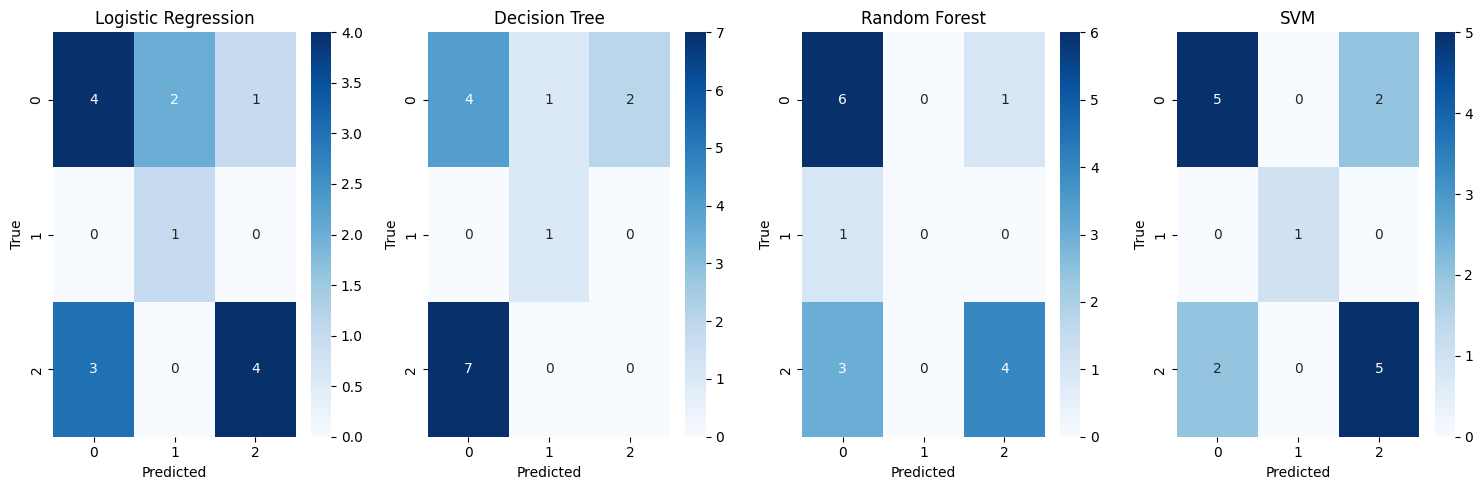

In [3]:
# Create a subplot grid to plot multiple confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=len(trained_models), figsize=(15, 5))

# Plot each confusion matrix using a heatmap
for i, model_name in enumerate(trained_models):
    sns.heatmap(conf_matrices[i], annot=True, cmap='Blues', fmt='g', ax=axes[i])
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

### 4.4 ROC

In [4]:
%%ignore
# Create the ROC curve plot using Plotly
# For single class
fig = go.Figure()

for model_name in trained_models:
    trained_models[model_name].fit(X_train, y_train)
    y_pred_prob = trained_models[model_name].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Add ROC curve trace for each classifier
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{model_name} (AUC = {roc_auc:.2f})'))

# Add diagonal line representing random guessing
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='gray', dash='dash'), name='Random Guessing'))

fig.update_layout(title='ROC Curve Comparison for Different Classifiers',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  legend_title='Classifiers',
                  showlegend=True)

fig.show()

UsageError: Cell magic `%%ignore` not found.


In [5]:
# Create the ROC curve plot using Plotly
# For multiple classes
for model_name in trained_models:
    fig = go.Figure()
    trained_models[model_name].fit(X_train, y_train)
    # Get the probabilities for each class
    y_prob = trained_models[model_name].predict_proba(X_test)
    # Calculate ROC curve and AUC for each class
    for i in range(len(trained_models[model_name].classes_)):
        fpr, tpr, _ = roc_curve(y_test == trained_models[model_name].classes_[i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Add ROC curve trace for each class
        fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', 
                                 name=f'{model_name} (Class {trained_models[model_name].classes_[i]}) (AUC = {roc_auc:.2f})'))

    # Add diagonal line representing random guessing
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='gray', dash='dash'), name='Random Guessing'))

    fig.update_layout(title='ROC for '+model_name+' (Multi-Class)',
                    xaxis_title='False Positive Rate',
                    yaxis_title='True Positive Rate',
                    xaxis_range=[0,1],yaxis_range=[0,1],
                    legend_title='Classifiers',
                    showlegend=True,
                    plot_bgcolor='white', paper_bgcolor='white',
                    xaxis=dict(linecolor='black'),
                    yaxis=dict(linecolor='black'),
                    legend=dict(orientation="h",
                                yanchor="top",y=-0.2,
                                xanchor="left",x=-0.2),
                    height=500, width=500)
    fig.show()

AttributeError: predict_proba is not available when  probability=False